# CHM Fractal Analysis: Barro Colorado Island

**Site:** Barro Colorado Island, Panama  
**Forest Type:** Tropical Moist Forest (Neotropical Lowland Rainforest)  
**Data Source:** [Smithsonian ALS Panama 2023](https://smithsonian.dataone.org/datasets/ALS_Panama_2023/)  
**Resolution:** 0.5m

## Research Hypotheses

This notebook tests fractal properties of the BCI tropical forest canopy:

1. **Optimal Filling (H1)** - Old-growth tropical forests maximize light interception, producing higher fractal dimensions than temperate forests
2. **Scale Invariance (H2)** - Mature tropical forests show scale-invariant gap distributions (power-law decay)
3. **Zeta Distribution (H3)** - Canopy gaps follow power-law with exponent related to optimal packing
4. **Universal Repulsion (H4)** - Emergent tree spacing follows competition-driven distributions
5. **Vertical Complexity (H5)** - Multi-layered tropical canopy shows higher complexity than single-layer temperate forests

## Methods

- **Differential Box Counting (DBC)** - Self-affine fractal dimension of height surfaces
- **Standard Box Counting** - Self-similar fractal dimension comparison
- **Lacunarity Analysis** - Scale invariance and gap texture
- **Gap Size Distribution** - Power-law vs exponential fitting
- **Nearest Neighbor Spacing** - Tree spacing statistics

## Expected Results for Tropical Forest

Based on BCI's multi-layered structure and high species diversity:
- **Fractal Dimension:** D > 2.5 (higher than temperate due to layering)
- **Scale Invariance:** High R² in lacunarity (mature forest)
- **Gap Distribution:** Power-law (continuous gap dynamics)

## 1. Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rioxarray as rxr
from pathlib import Path
from datetime import datetime
import json
from scipy import ndimage
from scipy.stats import ks_2samp, pearsonr, spearmanr
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.special import zeta
from rasterio.enums import Resampling
import warnings
warnings.filterwarnings('ignore')

print(f"Environment ready at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Environment ready at 2025-12-25 19:01:13


## 2. Configuration

In [2]:
# Site configuration
SITE_NAME = "bci_panama"
SITE_DESCRIPTION = "Barro Colorado Island - Tropical Moist Forest"

# Data paths
DATA_BASE = Path.home() / "data-store/data/output/smithsonian"
RAW_DATA = DATA_BASE / "raw"

# Input files
CHM_PATH = RAW_DATA / "chm" / "BCI_whole_2023_05_26_chm.tif"
DTM_PATH = RAW_DATA / "dtm" / "BCI_whole_2023_05_26_dtm.tif"

# Output directory
OUTPUT_DIR = DATA_BASE / "analysis" / "fractal"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Analysis parameters
GAP_THRESHOLD = 2.0  # meters - pixels below this are gaps
EMERGENT_THRESHOLD = 35.0  # meters - emergent tree detection
LOCAL_MAX_WINDOW = 21  # pixels - for tree top detection (10.5m at 0.5m resolution)

# Verify files exist
print("Input files:")
for name, path in [("CHM", CHM_PATH), ("DTM", DTM_PATH)]:
    exists = path.exists()
    size = f"{path.stat().st_size / 1e9:.2f} GB" if exists else "NOT FOUND"
    print(f"  [{('OK' if exists else 'MISSING')}] {name}: {path.name} ({size})")

print(f"\nOutput: {OUTPUT_DIR}")

Input files:
  [OK] CHM: BCI_whole_2023_05_26_chm.tif (1.14 GB)
  [OK] DTM: BCI_whole_2023_05_26_dtm.tif (1.14 GB)

Output: /home/jovyan/data-store/data/output/smithsonian/analysis/fractal


## 3. Load and Subset CHM

The full BCI CHM is 1.1 GB. For efficient analysis, we'll work with a representative subset.
You can analyze the full island by setting `USE_SUBSET = False`.

In [3]:
# Load CHM
print(f"Loading CHM from: {CHM_PATH.name}")
print("This may take a moment for the 1.1 GB file...")

chm_full = rxr.open_rasterio(CHM_PATH, masked=True)

print(f"\nFull CHM loaded:")
print(f"  Shape: {chm_full.shape}")
print(f"  CRS: {chm_full.rio.crs}")
print(f"  Resolution: {abs(chm_full.rio.resolution()[0]):.2f}m")
print(f"  Bounds: {chm_full.rio.bounds()}")

Loading CHM from: BCI_whole_2023_05_26_chm.tif
This may take a moment for the 1.1 GB file...

Full CHM loaded:
  Shape: (1, 11000, 13000)
  CRS: EPSG:32617
  Resolution: 0.50m
  Bounds: (623500.0, 1009500.0, 630000.0, 1015000.0)


In [23]:
# Option to use subset for faster analysis
USE_SUBSET = False
SUBSET_SIZE = 2000  # pixels (1km x 1km at 0.5m resolution)

if USE_SUBSET:
    # Get center region of the island (avoiding water edges)
    full_shape = chm_full.shape
    center_y = full_shape[1] // 2
    center_x = full_shape[2] // 2
    half_size = SUBSET_SIZE // 2
    
    # Extract subset
    chm = chm_full[:, 
                   center_y - half_size : center_y + half_size,
                   center_x - half_size : center_x + half_size]
    
    print(f"Using center subset: {SUBSET_SIZE}x{SUBSET_SIZE} pixels")
    print(f"  = {SUBSET_SIZE * 0.5 / 1000:.1f} km x {SUBSET_SIZE * 0.5 / 1000:.1f} km")
else:
    chm = chm_full
    print("Using full CHM (this may be slow)")

# Get the data array
chm_array = chm.values.squeeze().astype(np.float64)

# Get NoData value
NODATA_VALUE = chm.rio.nodata if chm.rio.nodata is not None else -9999

# Create masks
nodata_mask = np.isnan(chm_array) | (chm_array == NODATA_VALUE)
valid_mask = ~nodata_mask

# Get pixel resolution
pixel_resolution = abs(chm.rio.resolution()[0])

print(f"\nAnalysis array:")
print(f"  Shape: {chm_array.shape}")
print(f"  Valid pixels: {valid_mask.sum():,} ({100*valid_mask.sum()/chm_array.size:.1f}%)")
print(f"  Resolution: {pixel_resolution:.3f}m")

Using full CHM (this may be slow)

Analysis array:
  Shape: (11000, 13000)
  Valid pixels: 85,420,424 (59.7%)
  Resolution: 0.500m


In [24]:
# Basic height statistics for subset
valid_heights = chm_array[valid_mask]
# Filter to reasonable values
valid_heights = valid_heights[(valid_heights >= 0) & (valid_heights <= 80)]

print("Height Statistics (subset):")
print(f"  Min:    {np.min(valid_heights):.2f} m")
print(f"  Max:    {np.max(valid_heights):.2f} m")
print(f"  Mean:   {np.mean(valid_heights):.2f} m")
print(f"  Median: {np.median(valid_heights):.2f} m")
print(f"  Std:    {np.std(valid_heights):.2f} m")
print(f"  P95:    {np.percentile(valid_heights, 95):.2f} m")
print(f"  P99:    {np.percentile(valid_heights, 99):.2f} m")

Height Statistics (subset):
  Min:    0.00 m
  Max:    72.67 m
  Mean:   18.70 m
  Median: 19.66 m
  Std:    11.40 m
  P95:    35.93 m
  P99:    40.92 m


---

# HYPOTHESIS 1: Optimal Filling

**Prediction:** Tropical old-growth forests maximize light interception through multi-layered canopy structure, producing higher fractal dimensions than temperate forests.

**Method:** Differential Box Counting (DBC) for self-affine surfaces

**Expected Results:**
- D ∈ [2.0, 2.3]: Simple structure (plantation, young forest)
- D ∈ [2.3, 2.5]: Moderate complexity (disturbed or temperate)
- D ∈ [2.5, 2.8]: High complexity (old-growth, tropical multi-layer)
- D > 2.8: Very high complexity (exceptional tropical canopy)

In [25]:
def differential_box_counting(img, valid_mask, scales=None, min_valid_frac=0.8):
    """
    Compute fractal dimension using Differential Box Counting (Sarkar & Chaudhuri 1994).
    
    For self-affine surfaces (like canopy height models):
    - D = 2: Perfectly smooth planar surface
    - D = 3: Maximally rough space-filling surface
    
    Args:
        img: 2D height array
        valid_mask: Boolean mask of valid pixels
        scales: List of box sizes to use
        min_valid_frac: Minimum fraction of valid pixels in box
        
    Returns:
        D: Fractal dimension
        r2: R-squared of fit
        scales: Box sizes used
        Ns: Box counts at each scale
    """
    rows, cols = img.shape
    M = min(rows, cols)

    # Get height range from valid data
    valid_values = img[valid_mask]
    z_min_global, z_max_global = valid_values.min(), valid_values.max()
    z_range_global = z_max_global - z_min_global

    if z_range_global <= 0:
        return np.nan, 0.0, np.array([]), np.array([])

    # Default scales: powers of 2
    if scales is None:
        max_scale = M // 4
        scales = [2**i for i in range(1, 12) if 2**i <= max_scale]

    Ns_list = []
    valid_scales = []

    for s in scales:
        nx = cols // s
        ny = rows // s

        if nx < 1 or ny < 1:
            continue

        N_total = 0
        valid_boxes = 0

        for i in range(ny):
            for j in range(nx):
                y_start, y_end = i * s, (i + 1) * s
                x_start, x_end = j * s, (j + 1) * s

                box_data = img[y_start:y_end, x_start:x_end]
                box_valid = valid_mask[y_start:y_end, x_start:x_end]

                valid_frac = box_valid.sum() / (s * s)
                if valid_frac < min_valid_frac:
                    continue

                valid_boxes += 1
                valid_heights = box_data[box_valid]
                z_min_box = valid_heights.min()
                z_max_box = valid_heights.max()

                # Scale heights to grid
                z_min_scaled = (z_min_box - z_min_global) / z_range_global * M
                z_max_scaled = (z_max_box - z_min_global) / z_range_global * M

                k = int(np.floor(z_min_scaled / s))
                l = int(np.floor(z_max_scaled / s))
                n = l - k + 1

                N_total += n

        if valid_boxes > 0:
            Ns_list.append(N_total)
            valid_scales.append(s)

    if len(valid_scales) < 3:
        return np.nan, 0.0, np.array([]), np.array([])

    # Linear regression in log-log space
    log_inv_s = np.log(1.0 / np.array(valid_scales))
    log_Ns = np.log(np.array(Ns_list))

    coeffs = np.polyfit(log_inv_s, log_Ns, 1)
    D = coeffs[0]

    # R-squared
    predicted = np.polyval(coeffs, log_inv_s)
    ss_res = np.sum((log_Ns - predicted) ** 2)
    ss_tot = np.sum((log_Ns - np.mean(log_Ns)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    return D, r2, np.array(valid_scales), np.array(Ns_list)

In [26]:
print("="*70)
print("HYPOTHESIS 1: OPTIMAL FILLING")
print("="*70)
print("\nRunning Differential Box Counting (DBC)...")

D_dbc, r2_dbc, scales_dbc, Ns_dbc = differential_box_counting(
    chm_array, valid_mask, min_valid_frac=0.8
)

print(f"\nResults:")
print(f"  DBC Fractal Dimension: D = {D_dbc:.4f}")
print(f"  R-squared: {r2_dbc:.4f}")
print(f"  Scales used: {len(scales_dbc)} ({scales_dbc.min()}-{scales_dbc.max()} pixels)")

# Classification
if np.isnan(D_dbc):
    h1_class = "INSUFFICIENT_DATA"
    h1_interp = "Insufficient data for analysis"
elif D_dbc >= 2.7:
    h1_class = "EXCEPTIONAL_TROPICAL"
    h1_interp = f"D = {D_dbc:.2f} indicates EXCEPTIONAL complexity (multi-layered tropical)"
elif D_dbc >= 2.5:
    h1_class = "HIGH_COMPLEXITY"
    h1_interp = f"D = {D_dbc:.2f} indicates HIGH complexity (old-growth tropical)"
elif D_dbc >= 2.3:
    h1_class = "MODERATE_COMPLEXITY"
    h1_interp = f"D = {D_dbc:.2f} indicates MODERATE complexity (typical forest)"
else:
    h1_class = "LOW_COMPLEXITY"
    h1_interp = f"D = {D_dbc:.2f} indicates LOW complexity (simple structure)"

print(f"\nInterpretation: {h1_interp}")

# Store results
h1_results = {
    'hypothesis': 'H1: Optimal Filling',
    'method': 'Differential Box Counting (DBC)',
    'D_dbc': float(D_dbc) if not np.isnan(D_dbc) else None,
    'r_squared': float(r2_dbc),
    'n_scales': len(scales_dbc),
    'classification': h1_class,
    'interpretation': h1_interp
}

HYPOTHESIS 1: OPTIMAL FILLING

Running Differential Box Counting (DBC)...

Results:
  DBC Fractal Dimension: D = 2.4514
  R-squared: 0.9937
  Scales used: 11 (2-2048 pixels)

Interpretation: D = 2.45 indicates MODERATE complexity (typical forest)


Saved: bci_panama_h1_dbc.png


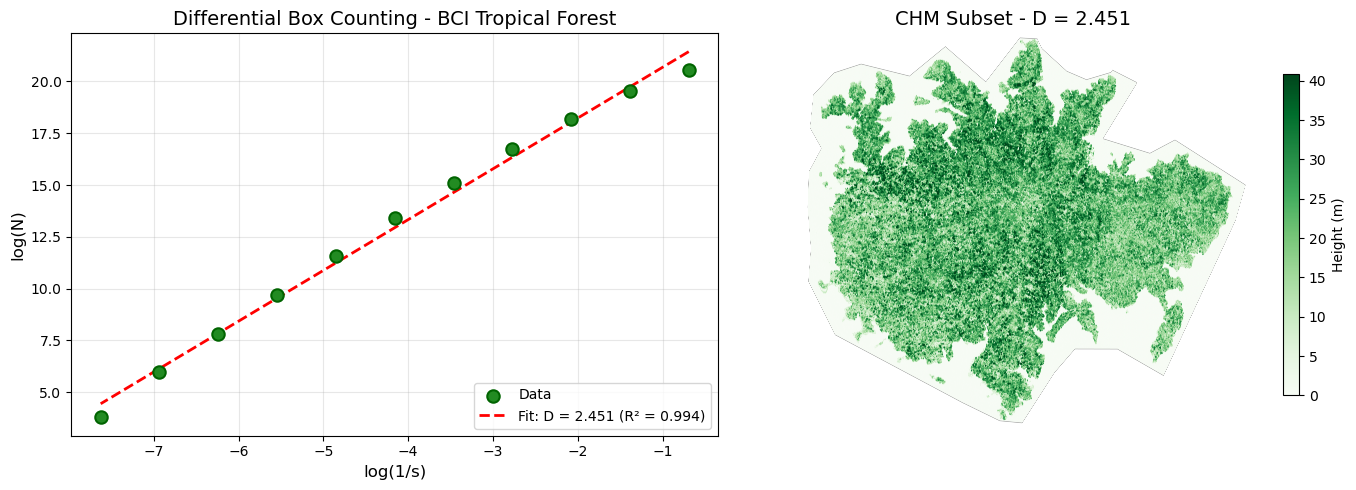

In [27]:
# Plot DBC results
if len(scales_dbc) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Log-log plot
    ax1 = axes[0]
    log_inv_s = np.log(1.0 / scales_dbc)
    log_Ns = np.log(Ns_dbc)
    
    ax1.scatter(log_inv_s, log_Ns, s=80, c='forestgreen', edgecolors='darkgreen', 
                linewidths=1.5, zorder=5, label='Data')
    
    # Fit line
    coeffs = np.polyfit(log_inv_s, log_Ns, 1)
    fit_line = np.polyval(coeffs, log_inv_s)
    ax1.plot(log_inv_s, fit_line, 'r--', linewidth=2, 
             label=f'Fit: D = {D_dbc:.3f} (R² = {r2_dbc:.3f})')
    
    ax1.set_xlabel('log(1/s)', fontsize=12)
    ax1.set_ylabel('log(N)', fontsize=12)
    ax1.set_title('Differential Box Counting - BCI Tropical Forest', fontsize=14)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # CHM visualization
    ax2 = axes[1]
    plot_data = np.ma.masked_where(~valid_mask, chm_array)
    im = ax2.imshow(plot_data, cmap='Greens', vmin=0, vmax=np.percentile(valid_heights, 99))
    ax2.set_title(f'CHM Subset - D = {D_dbc:.3f}', fontsize=14)
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, label='Height (m)', shrink=0.8)
    
    plt.tight_layout()
    
    # Save
    fig_path = OUTPUT_DIR / f"{SITE_NAME}_h1_dbc.png"
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"Saved: {fig_path.name}")
    
    plt.show()

---

# HYPOTHESIS 2: Scale Invariance

**Prediction:** Mature tropical forests show scale-invariant structure - gaps of all sizes following power-law decay.

**Method:** Lacunarity analysis using Gliding Box Algorithm

**Expected Results:**
- R² > 0.95: Strong scale invariance (mature old-growth)
- R² 0.7-0.95: Partial scale invariance (recovering forest)
- R² < 0.7: Characteristic scales present (disturbed or managed)

In [28]:
def gliding_box_lacunarity(img, valid_mask, box_sizes=None, min_valid_frac=0.5):
    """
    Calculate lacunarity using the Gliding Box Algorithm.
    
    Lacunarity measures "gappiness" at different scales:
    L(r) = (sigma^2 / mu^2) + 1
    
    Scale invariance: L(r) follows power law in log-log space
    
    Args:
        img: 2D height array
        valid_mask: Boolean mask of valid pixels
        box_sizes: List of box sizes
        min_valid_frac: Minimum fraction of valid pixels
        
    Returns:
        lacunarity: Array of lacunarity values
        sizes: Box sizes used
        r2: R-squared of log-log fit
        slope: Slope of log-log fit
    """
    rows, cols = img.shape
    
    img_clean = img.copy()
    img_clean[~valid_mask] = np.nan
    
    if box_sizes is None:
        max_size = min(rows, cols) // 4
        box_sizes = [2**i for i in range(2, 10) if 2**i <= max_size]
    
    lacunarity_values = []
    valid_sizes = []
    
    for r in box_sizes:
        box_sums = []
        
        # Gliding window with step size r/2
        step = max(1, r // 2)
        for i in range(0, rows - r + 1, step):
            for j in range(0, cols - r + 1, step):
                box = img_clean[i:i+r, j:j+r]
                box_valid = valid_mask[i:i+r, j:j+r]
                
                valid_frac = box_valid.sum() / (r * r)
                if valid_frac < min_valid_frac:
                    continue
                
                box_sum = np.nansum(box)
                box_sums.append(box_sum)
        
        if len(box_sums) < 10:
            continue
        
        box_sums = np.array(box_sums)
        mu = np.mean(box_sums)
        sigma2 = np.var(box_sums)
        
        L = (sigma2 / (mu ** 2)) + 1 if mu > 0 else 1.0
        
        lacunarity_values.append(L)
        valid_sizes.append(r)
    
    if len(valid_sizes) < 3:
        return np.array([]), np.array([]), 0.0, 0.0
    
    # Fit power law in log-log space
    log_r = np.log(np.array(valid_sizes))
    log_L = np.log(np.array(lacunarity_values))
    
    coeffs = np.polyfit(log_r, log_L, 1)
    slope = coeffs[0]
    
    predicted = np.polyval(coeffs, log_r)
    ss_res = np.sum((log_L - predicted) ** 2)
    ss_tot = np.sum((log_L - np.mean(log_L)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return np.array(lacunarity_values), np.array(valid_sizes), r2, slope

In [29]:
print("="*70)
print("HYPOTHESIS 2: SCALE INVARIANCE")
print("="*70)
print("\nRunning Lacunarity Analysis (Gliding Box)...")

lacunarity, lac_sizes, r2_lac, lac_slope = gliding_box_lacunarity(chm_array, valid_mask)

print(f"\nResults:")
print(f"  Scales analyzed: {len(lac_sizes)}")
print(f"  R² (log-log linearity): {r2_lac:.4f}")
print(f"  Slope: {lac_slope:.4f}")

# Classification
if r2_lac > 0.95:
    h2_class = "SCALE_INVARIANT"
    h2_interp = f"R² = {r2_lac:.3f} indicates STRONG scale invariance (mature old-growth)"
elif r2_lac > 0.80:
    h2_class = "MODERATE_INVARIANCE"
    h2_interp = f"R² = {r2_lac:.3f} indicates MODERATE scale invariance"
elif r2_lac > 0.60:
    h2_class = "PARTIAL_INVARIANCE"
    h2_interp = f"R² = {r2_lac:.3f} indicates PARTIAL scale invariance (some characteristic scales)"
else:
    h2_class = "CHARACTERISTIC_SCALES"
    h2_interp = f"R² = {r2_lac:.3f} indicates CHARACTERISTIC SCALES present"

print(f"\nInterpretation: {h2_interp}")

h2_results = {
    'hypothesis': 'H2: Scale Invariance',
    'method': 'Lacunarity (Gliding Box)',
    'r_squared': float(r2_lac),
    'slope': float(lac_slope),
    'n_scales': len(lac_sizes),
    'classification': h2_class,
    'interpretation': h2_interp
}

HYPOTHESIS 2: SCALE INVARIANCE

Running Lacunarity Analysis (Gliding Box)...

Results:
  Scales analyzed: 8
  R² (log-log linearity): 0.9709
  Slope: -0.0395

Interpretation: R² = 0.971 indicates STRONG scale invariance (mature old-growth)


Saved: bci_panama_h2_lacunarity.png


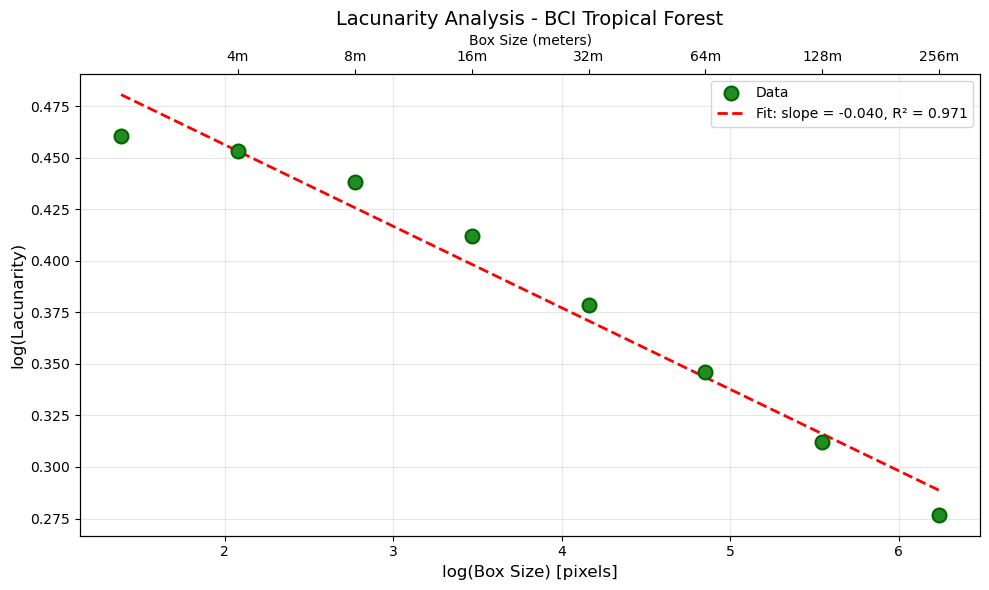

In [30]:
# Plot lacunarity results
if len(lac_sizes) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    log_r = np.log(lac_sizes)
    log_L = np.log(lacunarity)
    
    ax.scatter(log_r, log_L, s=100, c='forestgreen', edgecolors='darkgreen',
               linewidths=1.5, zorder=5, label='Data')
    
    # Fit line
    coeffs = np.polyfit(log_r, log_L, 1)
    fit_line = np.polyval(coeffs, log_r)
    ax.plot(log_r, fit_line, 'r--', linewidth=2,
            label=f'Fit: slope = {lac_slope:.3f}, R² = {r2_lac:.3f}')
    
    ax.set_xlabel('log(Box Size) [pixels]', fontsize=12)
    ax.set_ylabel('log(Lacunarity)', fontsize=12)
    ax.set_title('Lacunarity Analysis - BCI Tropical Forest', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add scale bar (convert pixels to meters)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    meter_ticks = [4, 8, 16, 32, 64, 128, 256]
    ax2.set_xticks([np.log(m / pixel_resolution) for m in meter_ticks if m / pixel_resolution <= lac_sizes.max()])
    ax2.set_xticklabels([f'{m}m' for m in meter_ticks if m / pixel_resolution <= lac_sizes.max()])
    ax2.set_xlabel('Box Size (meters)', fontsize=10)
    
    plt.tight_layout()
    
    fig_path = OUTPUT_DIR / f"{SITE_NAME}_h2_lacunarity.png"
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"Saved: {fig_path.name}")
    
    plt.show()

---

# HYPOTHESIS 3: Gap Size Distribution

**Prediction:** Canopy gaps in mature tropical forests follow a power-law distribution, reflecting self-organized gap dynamics.

**Method:** Gap size distribution fitting (power-law vs exponential)

**Expected Results:**
- Power-law (α ≈ 1.5-2.5): Natural gap dynamics (old-growth)
- Exponential: Random/managed gap creation

In [31]:
def identify_gaps(chm, valid_mask, gap_threshold=2.0, min_gap_pixels=4):
    """
    Identify contiguous gap regions in the CHM.
    
    Args:
        chm: 2D height array
        valid_mask: Boolean mask of valid pixels
        gap_threshold: Height below which pixels are considered gaps
        min_gap_pixels: Minimum number of pixels to count as a gap
        
    Returns:
        gap_areas: Array of gap sizes in pixels
        labeled: Labeled gap array
    """
    gap_mask = (chm < gap_threshold) & valid_mask
    labeled, num_features = ndimage.label(gap_mask)
    
    if num_features == 0:
        return np.array([]), labeled
    
    gap_areas = ndimage.sum(gap_mask, labeled, range(1, num_features + 1))
    gap_areas = gap_areas[gap_areas >= min_gap_pixels]
    
    return gap_areas, labeled


def fit_gap_distribution(gap_areas, resolution=1.0):
    """
    Fit power law and exponential distributions to gap sizes.
    
    Args:
        gap_areas: Gap sizes in pixels
        resolution: Pixel resolution in meters
        
    Returns:
        Dictionary with fit results
    """
    # Convert to m²
    areas = gap_areas * (resolution ** 2)
    areas = areas[areas > 0]
    
    if len(areas) < 20:
        return {'error': f'Insufficient gaps ({len(areas)}) for distribution fitting'}
    
    # Sort and compute CCDF
    sorted_areas = np.sort(areas)
    ecdf = np.arange(1, len(sorted_areas) + 1) / len(sorted_areas)
    ccdf = 1 - ecdf
    
    # Power law fit (in log-log space)
    try:
        mask = ccdf > 0.01  # Avoid log(0)
        log_x = np.log(sorted_areas[mask])
        log_ccdf = np.log(ccdf[mask])
        
        pl_coeffs = np.polyfit(log_x, log_ccdf, 1)
        alpha_pl = -pl_coeffs[0] + 1  # Power law exponent
        
        predicted_pl = np.polyval(pl_coeffs, log_x)
        ss_res_pl = np.sum((log_ccdf - predicted_pl) ** 2)
        ss_tot = np.sum((log_ccdf - np.mean(log_ccdf)) ** 2)
        r2_pl = 1 - (ss_res_pl / ss_tot) if ss_tot > 0 else 0
    except:
        alpha_pl = np.nan
        r2_pl = 0
    
    # Exponential fit
    try:
        x_vals = sorted_areas[mask]
        log_ccdf_exp = np.log(ccdf[mask])
        
        exp_coeffs = np.polyfit(x_vals, log_ccdf_exp, 1)
        beta_exp = -exp_coeffs[0]
        
        predicted_exp = np.polyval(exp_coeffs, x_vals)
        ss_res_exp = np.sum((log_ccdf_exp - predicted_exp) ** 2)
        r2_exp = 1 - (ss_res_exp / ss_tot) if ss_tot > 0 else 0
    except:
        beta_exp = np.nan
        r2_exp = 0
    
    return {
        'n_gaps': len(areas),
        'min_area_m2': float(areas.min()),
        'max_area_m2': float(areas.max()),
        'median_area_m2': float(np.median(areas)),
        'mean_area_m2': float(np.mean(areas)),
        'power_law': {'alpha': float(alpha_pl), 'r2': float(r2_pl)},
        'exponential': {'beta': float(beta_exp), 'r2': float(r2_exp)},
        'sorted_areas': sorted_areas,
        'ccdf': ccdf
    }

In [32]:
print("="*70)
print("HYPOTHESIS 3: GAP SIZE DISTRIBUTION")
print("="*70)
print(f"\nIdentifying gaps (height < {GAP_THRESHOLD}m)...")

gap_areas, labeled_gaps = identify_gaps(chm_array, valid_mask, GAP_THRESHOLD)
gap_results = fit_gap_distribution(gap_areas, pixel_resolution)

if 'error' in gap_results:
    print(f"Error: {gap_results['error']}")
    h3_class = "INSUFFICIENT_DATA"
    h3_interp = gap_results['error']
else:
    print(f"\nGap Statistics:")
    print(f"  Number of gaps: {gap_results['n_gaps']}")
    print(f"  Area range: {gap_results['min_area_m2']:.1f} - {gap_results['max_area_m2']:.1f} m²")
    print(f"  Median area: {gap_results['median_area_m2']:.1f} m²")
    
    print(f"\nPower Law Fit:")
    print(f"  α (exponent): {gap_results['power_law']['alpha']:.3f}")
    print(f"  R²: {gap_results['power_law']['r2']:.4f}")
    
    print(f"\nExponential Fit:")
    print(f"  R²: {gap_results['exponential']['r2']:.4f}")
    
    # Classification
    pl_r2 = gap_results['power_law']['r2']
    exp_r2 = gap_results['exponential']['r2']
    alpha = gap_results['power_law']['alpha']
    
    if pl_r2 > exp_r2 and pl_r2 > 0.7:
        h3_class = "POWER_LAW"
        h3_interp = f"Power law (α = {alpha:.2f}, R² = {pl_r2:.2f}) - natural gap dynamics"
    elif exp_r2 > pl_r2 and exp_r2 > 0.7:
        h3_class = "EXPONENTIAL"
        h3_interp = f"Exponential (R² = {exp_r2:.2f}) - random/managed gap creation"
    else:
        h3_class = "MIXED"
        h3_interp = f"Mixed distribution (PL R²={pl_r2:.2f}, Exp R²={exp_r2:.2f})"
    
    print(f"\nInterpretation: {h3_interp}")

h3_results = {
    'hypothesis': 'H3: Gap Size Distribution',
    'method': 'Power Law vs Exponential Fit',
    'n_gaps': gap_results.get('n_gaps', 0),
    'power_law_alpha': gap_results.get('power_law', {}).get('alpha'),
    'power_law_r2': gap_results.get('power_law', {}).get('r2'),
    'exponential_r2': gap_results.get('exponential', {}).get('r2'),
    'classification': h3_class,
    'interpretation': h3_interp
}

HYPOTHESIS 3: GAP SIZE DISTRIBUTION

Identifying gaps (height < 2.0m)...

Gap Statistics:
  Number of gaps: 3836
  Area range: 1.0 - 5858486.0 m²
  Median area: 3.5 m²

Power Law Fit:
  α (exponent): 1.819
  R²: 0.9678

Exponential Fit:
  R²: 0.6841

Interpretation: Power law (α = 1.82, R² = 0.97) - natural gap dynamics


Saved: bci_panama_h3_gap_distribution.png


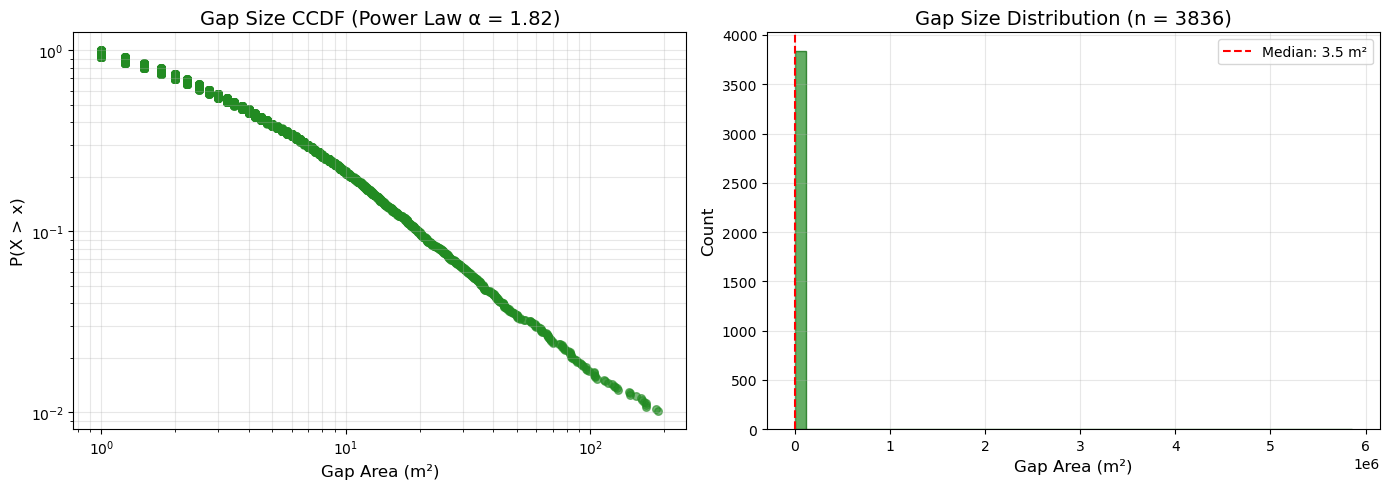

In [33]:
# Plot gap distribution
if 'sorted_areas' in gap_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sorted_areas = gap_results['sorted_areas']
    ccdf = gap_results['ccdf']
    
    # Log-log plot (power law test)
    ax1 = axes[0]
    mask = ccdf > 0.01
    ax1.scatter(sorted_areas[mask], ccdf[mask], s=30, alpha=0.6, c='forestgreen', label='Data')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Gap Area (m²)', fontsize=12)
    ax1.set_ylabel('P(X > x)', fontsize=12)
    ax1.set_title(f'Gap Size CCDF (Power Law α = {gap_results["power_law"]["alpha"]:.2f})', fontsize=14)
    ax1.grid(True, alpha=0.3, which='both')
    
    # Histogram
    ax2 = axes[1]
    ax2.hist(sorted_areas, bins=50, color='forestgreen', alpha=0.7, edgecolor='darkgreen')
    ax2.set_xlabel('Gap Area (m²)', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title(f'Gap Size Distribution (n = {gap_results["n_gaps"]})', fontsize=14)
    ax2.axvline(gap_results['median_area_m2'], color='red', linestyle='--', 
                label=f'Median: {gap_results["median_area_m2"]:.1f} m²')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    fig_path = OUTPUT_DIR / f"{SITE_NAME}_h3_gap_distribution.png"
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"Saved: {fig_path.name}")
    
    plt.show()

---

# HYPOTHESIS 4: Emergent Tree Spacing

**Prediction:** Emergent trees in tropical forests show competition-driven spacing patterns.

**Method:** Nearest neighbor distance analysis for emergent tree tops

**Expected Results:**
- Regular spacing: Competition-structured (old-growth)
- Random (Poisson): Young or disturbed forest
- Clustered: Regeneration patches

In [34]:
def detect_tree_tops(chm, valid_mask, min_height=15.0, window_size=21):
    """
    Detect tree tops as local maxima in the CHM.
    
    Args:
        chm: 2D height array
        valid_mask: Boolean mask of valid pixels
        min_height: Minimum height for tree detection (meters)
        window_size: Window size for local maximum detection (pixels)
        
    Returns:
        positions: Array of (row, col) positions
        heights: Array of heights at each position
    """
    # Apply minimum height threshold
    chm_filtered = np.where(valid_mask & (chm >= min_height), chm, -np.inf)
    
    # Find local maxima
    local_max = ndimage.maximum_filter(chm_filtered, size=window_size)
    is_peak = (chm_filtered == local_max) & (chm_filtered > -np.inf)
    
    # Get positions
    rows, cols = np.where(is_peak)
    heights = chm[rows, cols]
    
    return np.column_stack([rows, cols]), heights


def nearest_neighbor_analysis(positions, pixel_resolution=1.0):
    """
    Analyze nearest neighbor distances for tree positions.
    
    Args:
        positions: Array of (row, col) positions
        pixel_resolution: Pixel size in meters
        
    Returns:
        Dictionary with NN statistics
    """
    if len(positions) < 10:
        return {'error': f'Insufficient trees ({len(positions)}) for NN analysis'}
    
    # Build KD-tree
    tree = cKDTree(positions * pixel_resolution)
    
    # Query nearest neighbor for each point
    distances, _ = tree.query(positions * pixel_resolution, k=2)  # k=2 because first is self
    nn_distances = distances[:, 1]  # Second column is nearest neighbor
    
    # Calculate statistics
    mean_nn = np.mean(nn_distances)
    std_nn = np.std(nn_distances)
    
    # Clark-Evans R ratio (R = observed mean / expected random mean)
    # For random Poisson: E[r] = 1 / (2 * sqrt(density))
    area = (positions[:, 0].max() - positions[:, 0].min()) * \
           (positions[:, 1].max() - positions[:, 1].min()) * (pixel_resolution ** 2)
    density = len(positions) / area if area > 0 else 0
    expected_random = 0.5 / np.sqrt(density) if density > 0 else np.inf
    
    R = mean_nn / expected_random if expected_random > 0 else np.nan
    
    return {
        'n_trees': len(positions),
        'density_per_ha': density * 10000,
        'mean_nn_m': float(mean_nn),
        'std_nn_m': float(std_nn),
        'cv_nn': float(std_nn / mean_nn) if mean_nn > 0 else np.nan,
        'clark_evans_R': float(R),
        'nn_distances': nn_distances
    }

In [35]:
print("="*70)
print("HYPOTHESIS 4: EMERGENT TREE SPACING")
print("="*70)
print(f"\nDetecting emergent trees (height >= {EMERGENT_THRESHOLD}m)...")

tree_positions, tree_heights = detect_tree_tops(
    chm_array, valid_mask, 
    min_height=EMERGENT_THRESHOLD, 
    window_size=LOCAL_MAX_WINDOW
)

print(f"Detected {len(tree_positions)} emergent tree tops")

nn_results = nearest_neighbor_analysis(tree_positions, pixel_resolution)

if 'error' in nn_results:
    print(f"Error: {nn_results['error']}")
    h4_class = "INSUFFICIENT_DATA"
    h4_interp = nn_results['error']
else:
    print(f"\nEmergent Tree Statistics:")
    print(f"  Count: {nn_results['n_trees']}")
    print(f"  Density: {nn_results['density_per_ha']:.1f} trees/ha")
    print(f"  Mean NN distance: {nn_results['mean_nn_m']:.1f} m")
    print(f"  Std NN distance: {nn_results['std_nn_m']:.1f} m")
    print(f"  CV: {nn_results['cv_nn']:.3f}")
    print(f"\nClark-Evans R: {nn_results['clark_evans_R']:.3f}")
    
    # Interpret R
    # R < 1: Clustered
    # R = 1: Random (Poisson)
    # R > 1: Regular/dispersed
    R = nn_results['clark_evans_R']
    
    if R > 1.2:
        h4_class = "REGULAR"
        h4_interp = f"R = {R:.2f} indicates REGULAR spacing (competition-structured)"
    elif R > 0.8:
        h4_class = "RANDOM"
        h4_interp = f"R = {R:.2f} indicates RANDOM spacing (Poisson-like)"
    else:
        h4_class = "CLUSTERED"
        h4_interp = f"R = {R:.2f} indicates CLUSTERED spacing (aggregated)"
    
    print(f"\nInterpretation: {h4_interp}")

h4_results = {
    'hypothesis': 'H4: Emergent Tree Spacing',
    'method': 'Nearest Neighbor Analysis',
    'n_trees': nn_results.get('n_trees', 0),
    'density_per_ha': nn_results.get('density_per_ha'),
    'mean_nn_m': nn_results.get('mean_nn_m'),
    'clark_evans_R': nn_results.get('clark_evans_R'),
    'classification': h4_class,
    'interpretation': h4_interp
}

HYPOTHESIS 4: EMERGENT TREE SPACING

Detecting emergent trees (height >= 35.0m)...
Detected 8903 emergent tree tops

Emergent Tree Statistics:
  Count: 8903
  Density: 3.3 trees/ha
  Mean NN distance: 17.2 m
  Std NN distance: 12.6 m
  CV: 0.734

Clark-Evans R: 0.628

Interpretation: R = 0.63 indicates CLUSTERED spacing (aggregated)


Saved: bci_panama_h4_tree_spacing.png


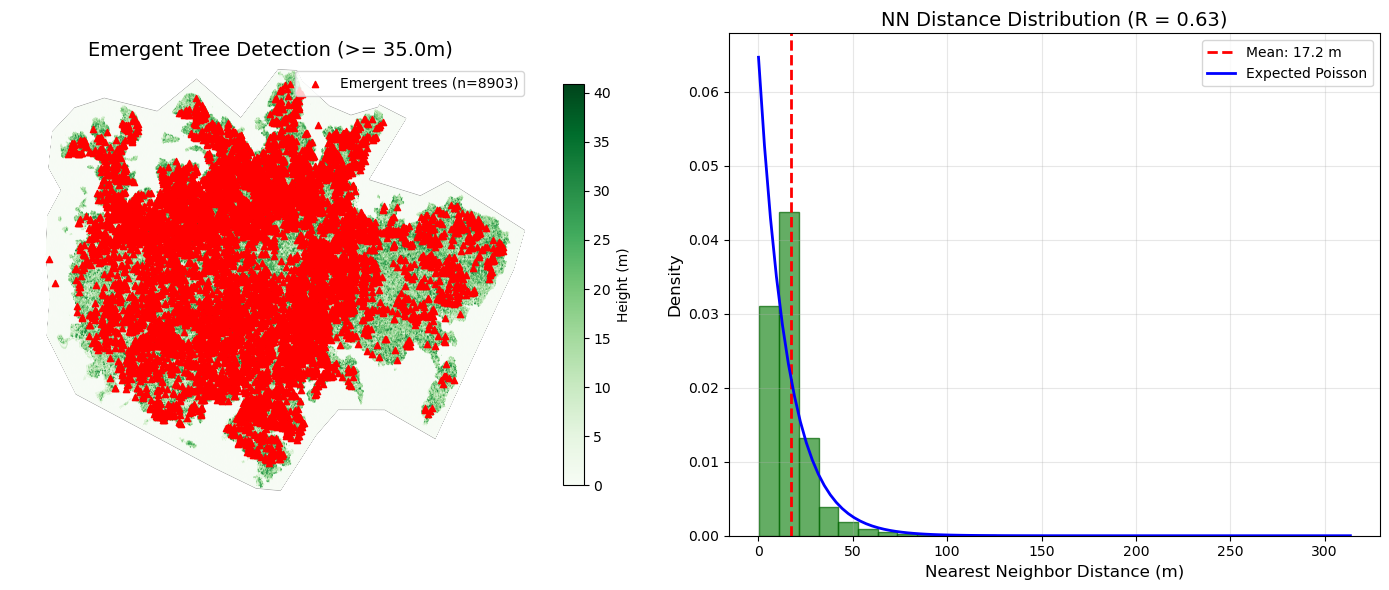

In [36]:
# Plot tree detection and NN distribution
if len(tree_positions) > 10:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Tree positions overlaid on CHM
    ax1 = axes[0]
    plot_data = np.ma.masked_where(~valid_mask, chm_array)
    im = ax1.imshow(plot_data, cmap='Greens', vmin=0, vmax=np.percentile(valid_heights, 99))
    ax1.scatter(tree_positions[:, 1], tree_positions[:, 0], 
                c='red', s=20, marker='^', label=f'Emergent trees (n={len(tree_positions)})')
    ax1.set_title(f'Emergent Tree Detection (>= {EMERGENT_THRESHOLD}m)', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.axis('off')
    plt.colorbar(im, ax=ax1, label='Height (m)', shrink=0.8)
    
    # NN distance distribution
    ax2 = axes[1]
    nn_dist = nn_results['nn_distances']
    ax2.hist(nn_dist, bins=30, color='forestgreen', alpha=0.7, edgecolor='darkgreen', density=True)
    ax2.axvline(nn_results['mean_nn_m'], color='red', linestyle='--', linewidth=2,
                label=f'Mean: {nn_results["mean_nn_m"]:.1f} m')
    
    # Expected Poisson distribution
    x_range = np.linspace(0, nn_dist.max(), 100)
    lambda_param = 2 * np.sqrt(nn_results['density_per_ha'] / 10000 * np.pi)
    poisson_pdf = lambda_param * np.exp(-lambda_param * x_range)
    ax2.plot(x_range, poisson_pdf, 'b-', linewidth=2, label='Expected Poisson')
    
    ax2.set_xlabel('Nearest Neighbor Distance (m)', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.set_title(f'NN Distance Distribution (R = {nn_results["clark_evans_R"]:.2f})', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    fig_path = OUTPUT_DIR / f"{SITE_NAME}_h4_tree_spacing.png"
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"Saved: {fig_path.name}")
    
    plt.show()

---

# Summary and Comparison

In [37]:
# Compile all results
all_results = {
    'site': {
        'name': SITE_NAME,
        'description': SITE_DESCRIPTION,
        'subset_used': USE_SUBSET,
        'subset_size_pixels': SUBSET_SIZE if USE_SUBSET else None,
        'resolution_m': float(pixel_resolution),
        'analysis_date': datetime.now().isoformat()
    },
    'height_stats': {
        'mean_m': float(np.mean(valid_heights)),
        'median_m': float(np.median(valid_heights)),
        'max_m': float(np.max(valid_heights)),
        'std_m': float(np.std(valid_heights)),
        'p95_m': float(np.percentile(valid_heights, 95)),
        'p99_m': float(np.percentile(valid_heights, 99))
    },
    'hypotheses': {
        'H1_optimal_filling': h1_results,
        'H2_scale_invariance': h2_results,
        'H3_gap_distribution': h3_results,
        'H4_tree_spacing': h4_results
    }
}

# Print summary
print("\n" + "="*70)
print("FRACTAL ANALYSIS SUMMARY - BARRO COLORADO ISLAND")
print("="*70)

print(f"\nSite: {SITE_DESCRIPTION}")
print(f"Resolution: {pixel_resolution}m")
print(f"Mean canopy height: {np.mean(valid_heights):.1f} m")
print(f"Max canopy height: {np.max(valid_heights):.1f} m")

print(f"\n" + "-"*70)
print("HYPOTHESIS RESULTS")
print("-"*70)

hypotheses = [
    ('H1', 'Optimal Filling (DBC)', h1_results),
    ('H2', 'Scale Invariance (Lacunarity)', h2_results),
    ('H3', 'Gap Distribution', h3_results),
    ('H4', 'Tree Spacing', h4_results)
]

for code, name, results in hypotheses:
    print(f"\n{code}: {name}")
    print(f"   Classification: {results.get('classification', 'N/A')}")
    print(f"   {results.get('interpretation', 'N/A')}")


FRACTAL ANALYSIS SUMMARY - BARRO COLORADO ISLAND

Site: Barro Colorado Island - Tropical Moist Forest
Resolution: 0.5m
Mean canopy height: 18.7 m
Max canopy height: 72.7 m

----------------------------------------------------------------------
HYPOTHESIS RESULTS
----------------------------------------------------------------------

H1: Optimal Filling (DBC)
   Classification: MODERATE_COMPLEXITY
   D = 2.45 indicates MODERATE complexity (typical forest)

H2: Scale Invariance (Lacunarity)
   Classification: SCALE_INVARIANT
   R² = 0.971 indicates STRONG scale invariance (mature old-growth)

H3: Gap Distribution
   Classification: POWER_LAW
   Power law (α = 1.82, R² = 0.97) - natural gap dynamics

H4: Tree Spacing
   Classification: CLUSTERED
   R = 0.63 indicates CLUSTERED spacing (aggregated)


In [38]:
# Compare with expected temperate forest values
print("\n" + "="*70)
print("TROPICAL VS TEMPERATE COMPARISON")
print("="*70)

# Reference values from 3DEP temperate forest analyses
temperate_reference = {
    'D_dbc': 2.3,  # Typical temperate forest
    'lacunarity_r2': 0.85,
    'gap_alpha': 1.8,
    'description': 'Typical US temperate forest (3DEP sites)'
}

print(f"\n{'Metric':<30} {'BCI Tropical':<20} {'Temperate Ref':<20}")
print("-"*70)

if h1_results.get('D_dbc'):
    d_diff = h1_results['D_dbc'] - temperate_reference['D_dbc']
    print(f"{'Fractal Dimension (D)':<30} {h1_results['D_dbc']:<20.3f} {temperate_reference['D_dbc']:<20.3f}")
    if d_diff > 0.1:
        print(f"   -> BCI shows HIGHER complexity (D +{d_diff:.2f})")
    elif d_diff < -0.1:
        print(f"   -> BCI shows LOWER complexity (D {d_diff:.2f})")
    else:
        print(f"   -> Similar complexity to temperate")

print(f"{'Lacunarity R²':<30} {h2_results.get('r_squared', 'N/A'):<20.3f} {temperate_reference['lacunarity_r2']:<20.3f}")

if h3_results.get('power_law_alpha'):
    print(f"{'Gap Power Law α':<30} {h3_results['power_law_alpha']:<20.3f} {temperate_reference['gap_alpha']:<20.3f}")


TROPICAL VS TEMPERATE COMPARISON

Metric                         BCI Tropical         Temperate Ref       
----------------------------------------------------------------------
Fractal Dimension (D)          2.451                2.300               
   -> BCI shows HIGHER complexity (D +0.15)
Lacunarity R²                  0.971                0.850               
Gap Power Law α                1.819                1.800               


In [39]:
# Save results to JSON
results_path = OUTPUT_DIR / f"{SITE_NAME}_fractal_results.json"

# Remove numpy arrays (not JSON serializable)
def clean_for_json(obj):
    if isinstance(obj, dict):
        return {k: clean_for_json(v) for k, v in obj.items() 
                if not isinstance(v, np.ndarray)}
    elif isinstance(obj, (np.floating, np.integer)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return None
    return obj

clean_results = clean_for_json(all_results)

with open(results_path, 'w') as f:
    json.dump(clean_results, f, indent=2)

print(f"\nResults saved to: {results_path}")


Results saved to: /home/jovyan/data-store/data/output/smithsonian/analysis/fractal/bci_panama_fractal_results.json


In [40]:
print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

print(f"\nOutput files in: {OUTPUT_DIR}")
for f in sorted(OUTPUT_DIR.glob(f"{SITE_NAME}*")):
    print(f"  - {f.name}")

print(f"\nKey Findings for BCI Tropical Forest:")
if h1_results.get('D_dbc'):
    print(f"  - Fractal Dimension: D = {h1_results['D_dbc']:.3f} ({h1_results['classification']})")
print(f"  - Scale Invariance: R² = {h2_results.get('r_squared', 0):.3f} ({h2_results['classification']})")
print(f"  - Gap Distribution: {h3_results['classification']}")
print(f"  - Tree Spacing: {h4_results['classification']}")


ANALYSIS COMPLETE

Output files in: /home/jovyan/data-store/data/output/smithsonian/analysis/fractal
  - bci_panama_fractal_results.json
  - bci_panama_h1_dbc.png
  - bci_panama_h2_lacunarity.png
  - bci_panama_h3_gap_distribution.png
  - bci_panama_h4_tree_spacing.png

Key Findings for BCI Tropical Forest:
  - Fractal Dimension: D = 2.451 (MODERATE_COMPLEXITY)
  - Scale Invariance: R² = 0.971 (SCALE_INVARIANT)
  - Gap Distribution: POWER_LAW
  - Tree Spacing: CLUSTERED


## Cleanup

In [41]:
# Free memory
chm_full.close()
if USE_SUBSET:
    chm.close()

del chm_array, valid_mask, valid_heights

import gc
gc.collect()

print("Memory cleaned up.")

Memory cleaned up.


---

## References

1. **Sarkar & Chaudhuri (1994)** - Differential Box Counting method for fractal dimension
2. **Plotnick et al. (1996)** - Lacunarity analysis of spatial patterns
3. **Clark & Evans (1954)** - Nearest neighbor analysis for spatial patterns
4. **Smithsonian ALS Panama 2023** - https://smithsonian.dataone.org/datasets/ALS_Panama_2023/
5. **BCI Forest Dynamics Plot** - https://forestgeo.si.edu/sites/neotropics/barro-colorado-island
6. **3DEP Fractal Analysis Framework** - Adapted from fractal-notebooks/docs/notebooks/3dep/